In [105]:
import tqdm
import numpy as np
import scipy
import torch
import torch.nn as nn
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split

In [163]:
plt.rcParams["figure.dpi"] = 100
plot_size = 9

In [180]:
viz_samples = 100000
viz_dotsize = 125

dotsize = 25

In [107]:
variant = "moons"
# variant = 'blobs'

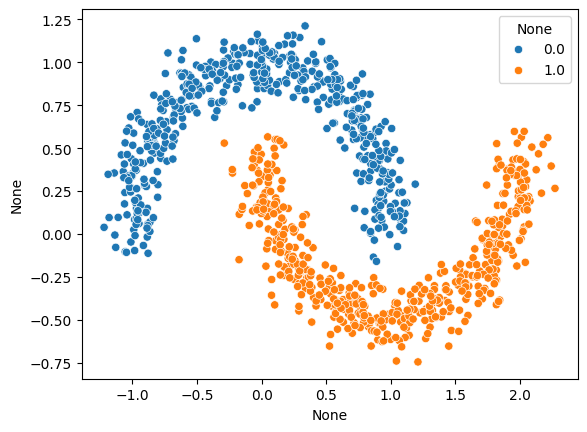

In [ ]:
if variant == "moons":
    X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape(-1, 1)
    train_x, test_x, train_y, test_y = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    sns.scatterplot(x=X.T[0], y=X.T[1], hue=y.reshape(-1))

else:
    X, y = make_blobs(
        n_samples=1000, centers=[[-2, -2], [2, 2]], n_features=2, random_state=42
    )
    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape(-1, 1)
    train_x, test_x, train_y, test_y = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    sns.scatterplot(x=X.T[0], y=X.T[1], hue=y.reshape(-1))

In [109]:
def get_grad_norm(model, loss_fn, x, y):
    model.zero_grad()
    loss = loss_fn(model(x), y)
    loss.backward()

    grads = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grads.append(param.grad.flatten())

    return torch.norm(torch.cat(grads))

In [111]:
if variant == "moons":
    dim = 5.5
else:
    dim = 25.5

viz_x = np.linspace((-dim, -dim), (dim, dim), viz_samples)
viz_x = torch.tensor(
    np.random.default_rng().permuted(viz_x.T, axis=1).T, dtype=torch.float32
)

In [112]:
def get_grad_norm_grid(model, loss_fn, samples):
    viz_grad = []

    for x in samples:
        viz_grad.append(
            get_grad_norm(
                model, loss_fn, x.reshape(1, -1), model(x.reshape(1, -1)).round()
            )
        )

    return torch.tensor(viz_grad)

In [113]:
if variant == "moons":

    class Model(nn.Module):
        def __init__(self, hidden_size=1028):
            super().__init__()
            self.layer_1 = nn.Linear(2, hidden_size)
            self.layer_2 = nn.Linear(hidden_size, 1)
            self.act = nn.ReLU()
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.sigmoid(self.layer_1(x))
            x = self.sigmoid(self.layer_2(x))
            return x

else:

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.layer_1 = nn.Linear(2, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.sigmoid(self.layer_1(x))
            return x

In [ ]:
model = Model()
epochs = 100

checkpoints = [1, 2, 5, 10, 50, 100]
grad_norm_grids = {}

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

grad_norm_grids[0] = get_grad_norm_grid(model, loss_fn, viz_x)

for n in tqdm.tqdm(range(epochs)):
    for i in range(len(train_x)):
        y_hat = model(train_x[i].reshape(1, -1))
        loss = loss_fn(y_hat, train_y[i].reshape(-1, 1))
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    if n + 1 in checkpoints:
        grad_norm_grids[n + 1] = get_grad_norm_grid(model, loss_fn, viz_x)

model.eval()

with torch.no_grad():
    y_hat = model(test_x)

with torch.no_grad():
    viz_y_hat = model(viz_x)

100%|██████████| 100/100 [03:57<00:00,  2.38s/it]


In [ ]:
def draw_grad_norm_grid(
    test_x,
    test_y,
    viz_x,
    grad_norm_grid,
    ax,
    title=None,
    palette="rocket_r",
    cbar=False,
):
    sns.scatterplot(
        x=viz_x.T[0],
        y=viz_x.T[1],
        hue=grad_norm_grid,
        marker=".",
        edgecolor=None,
        legend=None,
        palette=palette,
        linewidth=0,
        s=viz_dotsize,
        ax=ax,
    )
    sns.scatterplot(
        x=test_x.T[0], y=test_x.T[1], hue=test_y, edgecolor="black", s=dotsize, ax=ax
    )
    ax.get_legend().set_title(None)
    ax.set_ylabel(None)
    ax.set_xlabel(None)

    if cbar:
        norm = plt.Normalize(grad_norm_grid.min(), grad_norm_grid.max())
        sm = plt.cm.ScalarMappable(cmap="rocket_r", norm=norm)
        sm.set_array([])
        ax.figure.colorbar(sm, ax=ax)

    ax.set_title(title)

In [136]:
grad_norm_grids[0]

tensor([9.7969, 7.8594, 8.2261,  ..., 8.8630, 7.9235, 8.5251])

In [140]:
viz_loss_0 = []
viz_loss_1 = []
viz_loss_max = []
viz_loss_avg = []

viz_grad = []

for x in tqdm.tqdm(viz_x):
    viz_x_y_hat = model(x.reshape(1, -1))
    loss_0 = loss_fn(viz_x_y_hat, torch.tensor([[0.0]])).item()
    loss_1 = loss_fn(viz_x_y_hat, torch.tensor([[1.0]])).item()

    viz_loss_0.append(loss_0)
    viz_loss_1.append(loss_1)
    viz_loss_max.append(max(loss_0, loss_1))
    viz_loss_avg.append(np.mean((loss_0, loss_1)))

viz_loss_0 = torch.tensor(viz_loss_0)
viz_loss_1 = torch.tensor(viz_loss_1)
viz_loss_max = torch.tensor(viz_loss_max)
viz_loss_avg = torch.tensor(viz_loss_avg)

100%|██████████| 100000/100000 [00:06<00:00, 14789.82it/s]


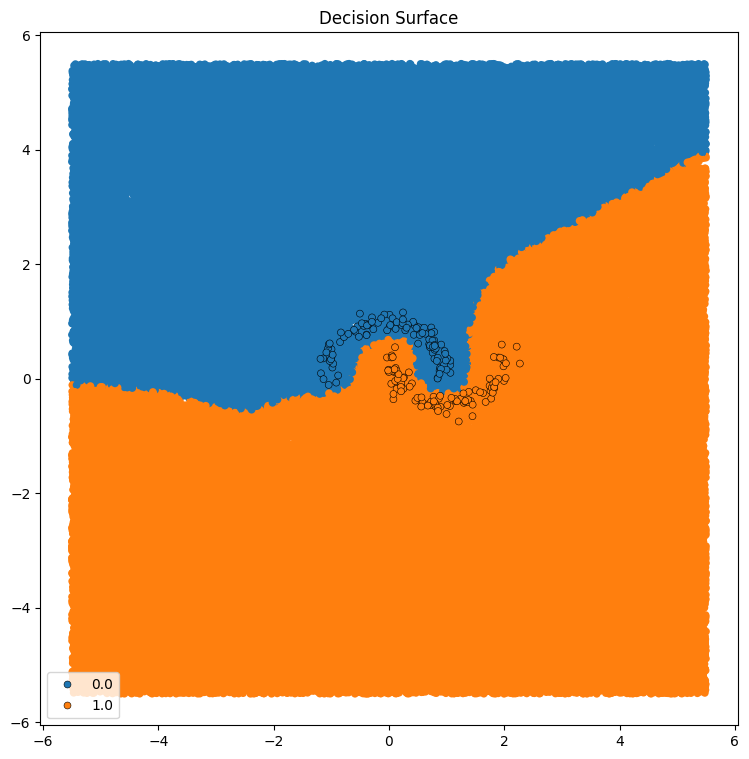

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(plot_size, plot_size))

draw_grad_norm_grid(
    test_x,
    y_hat.T[0].round(),
    viz_x,
    viz_y_hat.T[0].round(),
    ax,
    title="Decision Surface",
    palette="tab10",
)

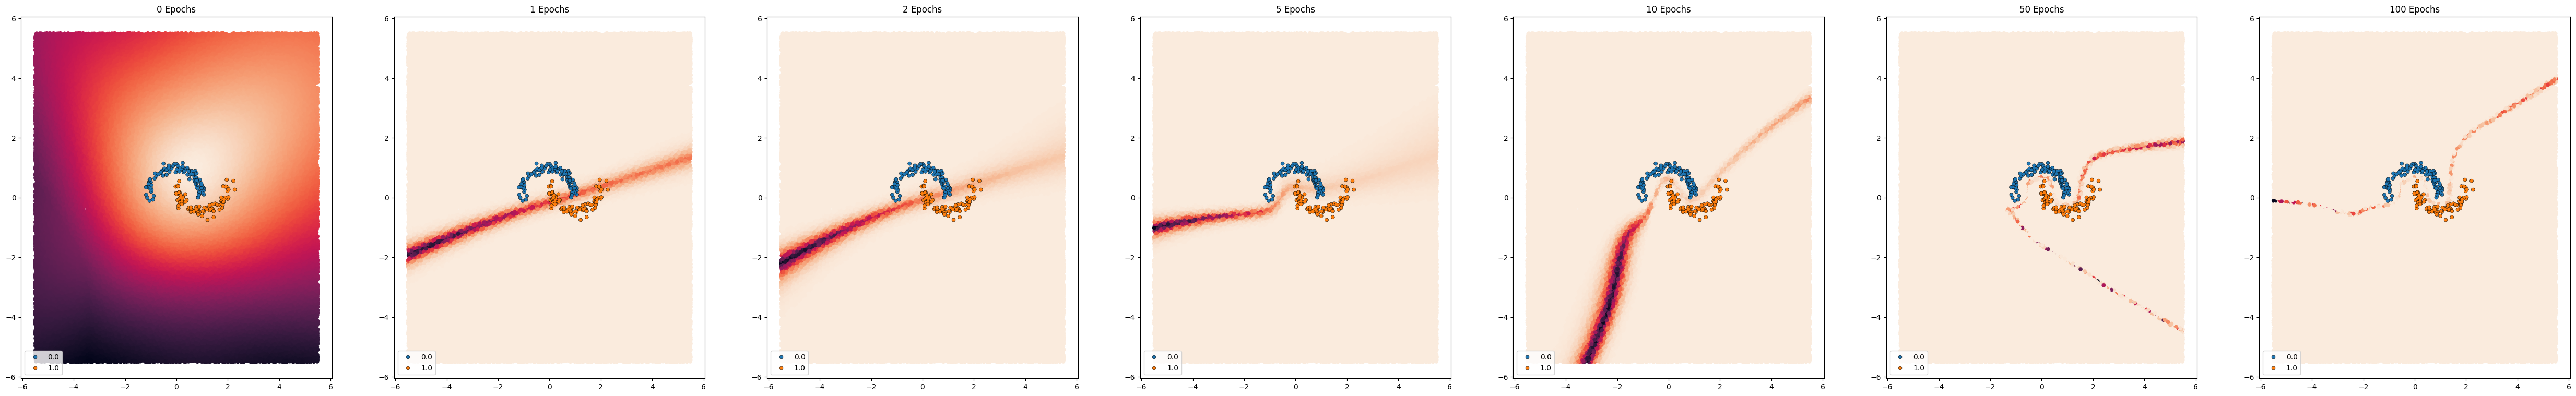

In [182]:
fig, axs = plt.subplots(
    1, len(grad_norm_grids), figsize=(len(grad_norm_grids) * plot_size, plot_size)
)
for i, checkpoint in enumerate(grad_norm_grids):
    draw_grad_norm_grid(
        test_x,
        y_hat.T[0].round(),
        viz_x,
        grad_norm_grids[checkpoint],
        axs[i],
        title=f"{checkpoint} Epochs",
    )

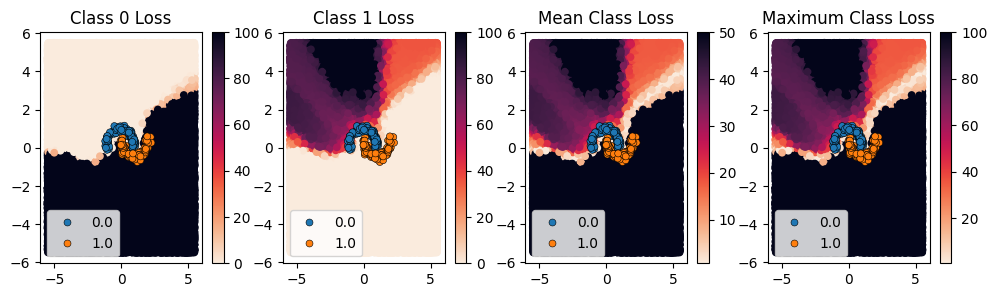

In [184]:
plot_size = 3
fig, axs = plt.subplots(1, 4, figsize=(4 * plot_size, plot_size))

draw_grad_norm_grid(
    test_x,
    y_hat.T[0].round(),
    viz_x,
    viz_loss_0,
    axs[0],
    title="Class 0 Loss",
    cbar=True,
)
draw_grad_norm_grid(
    test_x,
    y_hat.T[0].round(),
    viz_x,
    viz_loss_1,
    axs[1],
    title="Class 1 Loss",
    cbar=True,
)
draw_grad_norm_grid(
    test_x,
    y_hat.T[0].round(),
    viz_x,
    viz_loss_avg,
    axs[2],
    title="Mean Class Loss",
    cbar=True,
)
draw_grad_norm_grid(
    test_x,
    y_hat.T[0].round(),
    viz_x,
    viz_loss_max,
    axs[3],
    title="Maximum Class Loss",
    cbar=True,
)